### Essential Imports

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import image

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



sns.set_palette('Paired')
sns.set_style("whitegrid")

In [2]:
# class1 = 'Very_Mild_Demented/'
# class2 = 'Mild_Demented/'
# class3 = 'Moderate_Demented/'
# class0 = 'Non_Demented/'


class1 = '/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/'
class2 = '/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/'
class3 = '/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/'
class0 = '/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/'

### Step 1 : Data Extraction / Cleaning / Aggregation

1. In this step, data is extracted from each source, cleaned, resized, flattened and finally combined with all the sources to form an aggreagated dataframe that consists of all the classes.

In [3]:
def file_append(class_path):    
    image_array = []    
    curr_path = os.path.join(os.getcwd(),class_path)
    cnt = 0
    file_list = [k for k in os.listdir(curr_path) if '.jpg' in k]
    for x in file_list:
        
        img_path = os.path.join(curr_path,x)

        img = imread(img_path)
#         img = rgb2gray(img)
        img = resize(img,(60,60,3))     ## Will need to change this resize parameter
        img = img.flatten()
        image_array.append(img)
        
    return image_array
    

class1_img = file_append(class1)
class2_img = file_append(class2)
class3_img = file_append(class3)
class0_img = file_append(class0)


In [4]:
df1 = pd.DataFrame(class1_img)
df1['y']  = 1
df2 = pd.DataFrame(class2_img)
df2['y']  = 2
df3 = pd.DataFrame(class3_img)
df3['y']  = 3
df0 = pd.DataFrame(class0_img)
df0['y']  = 0

df = pd.concat([df0,df1,df2,df3],ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,10791,10792,10793,10794,10795,10796,10797,10798,10799,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Step 1.1 : Checking for null values

In [5]:
df.isnull().sum().sum()

0

## Step 2 : EDA of variable

Text(0.5, 1.0, 'Class Wise Distribution of data')

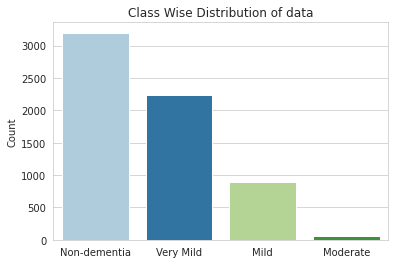

In [6]:
sns.barplot(x =['Non-dementia','Very Mild', 'Mild', 'Moderate'],y = df['y'].value_counts())
plt.ylabel('Count')
plt.title('Class Wise Distribution of data')

This distribution makes sense, as the percentage of people who have severe cases is much lower than mild cases.


## Step 3 : Splitting entire dataset into train and test sets

In [7]:
X,y = df[df.columns[:-1]],df['y']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=121)



## Step 4 : Data Preprocessing pipeline for scaling and dimensionality reduction

In [8]:
data_pipe = Pipeline([('scaler', StandardScaler()), ('pca',PCA(n_components=0.9))])
data_pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9))])

In [9]:
X_train = data_pipe.transform(X_train)
X_test = data_pipe.transform(X_test)

y_train

1077    1
19      0
4599    0
5144    1
1627    1
       ..
2113    0
3572    3
1631    0
4565    1
3394    0
Name: y, Length: 5120, dtype: int64

In [10]:
# pca = PCA(n_components=0.90)
# pca_data = pca.fit_transform(X_train)
# exp_var = pca.explained_variance_ratio_

print(f"Original Data dimension: {df.shape[1]} features")
print(f"After PCA Data dimension: {X_train.shape[1]} features")

Original Data dimension: 10801 features
After PCA Data dimension: 548 features


Text(0.5, 1.0, 'Variance Ratio for top 10 Principal Components')

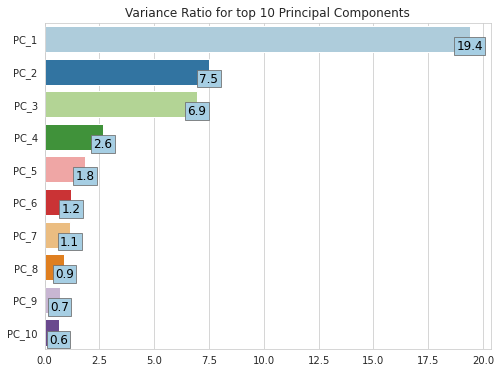

In [11]:
top10_var = [x*100 for x in data_pipe.named_steps['pca'].explained_variance_ratio_[:10]]
PC_labels = ['PC_'+str(x+1) for x in range(len(top10_var)) ]

plt.figure(figsize=(8,6))
plt.title("Variance Percentage for top 10 Principal Components")

bar = sns.barplot(x = top10_var,y = PC_labels)
for p in bar.patches:
    x = p.get_width()
    y = p.get_y()
    bar.annotate(format(x,'.1f'),(x,y),ha = 'center', va = 'center',size=12,color='black',xytext = (0, -20), textcoords = 'offset points',bbox = dict(boxstyle = 'square, pad = 0.2', lw = 0.8, ec = '#6e6e6e'))
#     print(p.get_width())
    
plt.title("Variance Ratio for top 10 Principal Components")


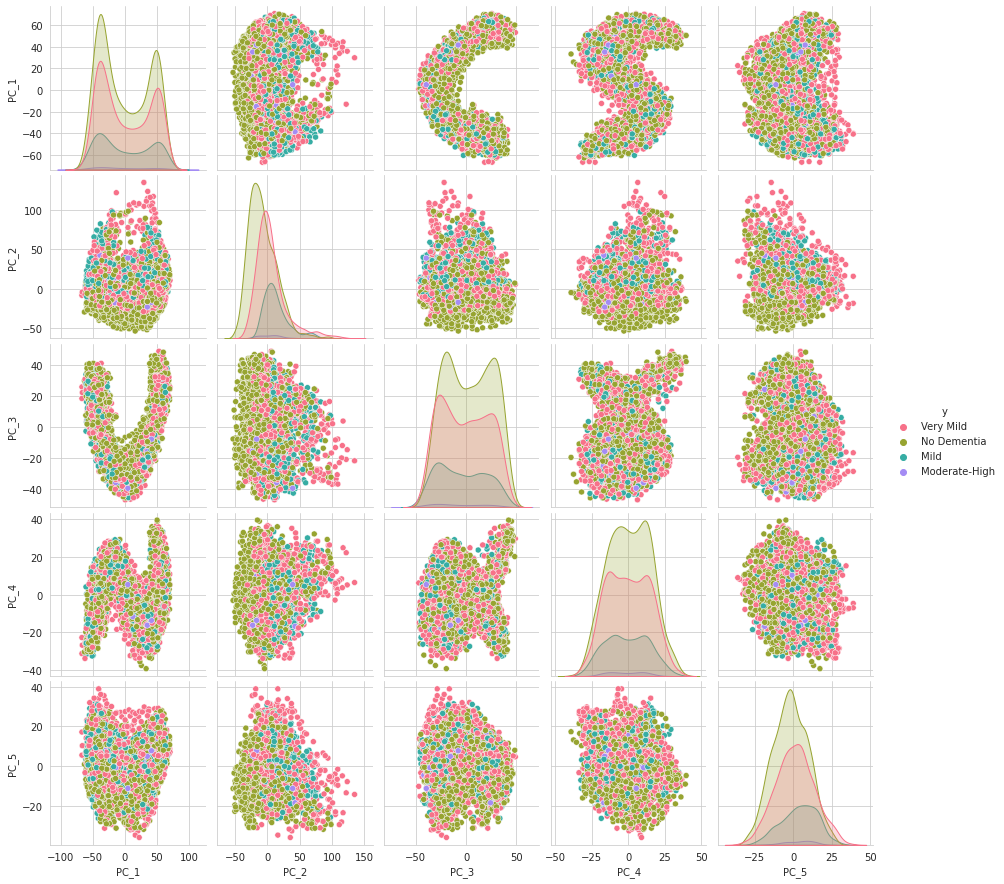

In [12]:
scatter_plots = X_train[:,:5]
data_cols = ['PC_'+str(x+1) for x in range(scatter_plots.shape[1]) ]
scatter_df = pd.DataFrame(scatter_plots,columns=data_cols)
scatter_df['y'] = y_train.reset_index(drop=True)

label_map = {0:'No Dementia',1:'Very Mild', 2: 'Mild',3:'Moderate-High'}
scatter_df['y'] = scatter_df['y'].map(label_map)

sns.pairplot(scatter_df,hue="y",palette="husl",)



From the above plot, it is very clear that , the data is not separable in lower dimensions, as we can see in scatter plots. Hence it is not easy to find a linearly separable boundary, thus it is my assumption that we might need to opt for SVM or other methods for high accuracy.

## Step 5 : Data Modelling

In [13]:
#Base function for models

def train_model(model,search_grid):
    cv = KFold(n_splits=10)
    grid_search = GridSearchCV(estimator=model, param_grid=search_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train,y_train)
    
    return grid_result

def scatter_plots(score_array,title):
    sns.set_palette('CMRmap')
    lr_scores = [max(score_array.cv_results_['split'+str(i)+'_test_score']) for i in range(0,10)]
    sns.lineplot(range(1,11),lr_scores)
    j = plt.scatter(range(1,11),lr_scores)
    
    plt.xlabel('Cross Validation Steps')
    plt.ylabel('Model Accuracy')
    plt.title(f'Cross Validation Accuracies for {title}',size=15)

    for i,j in enumerate(lr_scores):
        if j == max(lr_scores):
            plt.scatter(i+1,j,c='red',marker='o',s=200)
            plt.annotate(format(j,'.3f'),(i+1,j),size=15)
            
def cf_plot(score_array,title):
    plt.figure(figsize=(9,7))
    cf_matrix = confusion_matrix(y_test,y_pred=score_array.predict(X_test))
#     sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=0), annot=True, fmt='.2%', cmap='Blues',annot_kws={"size":15})

    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues',annot_kws={"size":15})

    plt.xlabel('Predicted Label',size=15)
    plt.ylabel('Actual Label',size=15)
    plt.title(f'Confusion Matrix for {title}',size=15)
    print(classification_report(y_test,y_pred=score_array.predict(X_test)))

### Step 5.1 Logistic Regression

In [14]:
lr_model = LogisticRegression(max_iter=100)

solvers = ['newton-cg']
penalty = ['l2','l3']
c_values = [ 1.0, 0.1, 0.01,0.001]
lr_search_grid = dict(solver=solvers,penalty=penalty,C=c_values)


lr_grid_result = train_model(lr_model,lr_search_grid)
# # grid_result.cv_results_



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    % (all_penalties, penalty)
ValueError: L

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


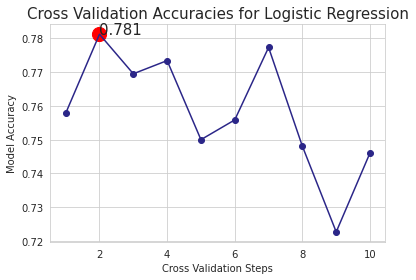

In [15]:
scatter_plots(lr_grid_result,'Logistic Regression')

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       643
           1       0.67      0.67      0.67       438
           2       0.78      0.66      0.72       190
           3       1.00      0.56      0.71         9

    accuracy                           0.75      1280
   macro avg       0.81      0.68      0.73      1280
weighted avg       0.75      0.75      0.75      1280



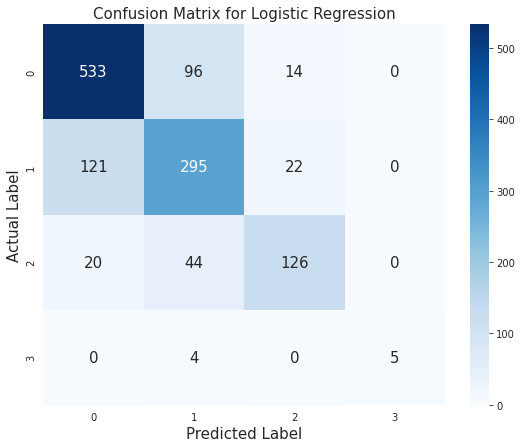

In [16]:
cf_plot(lr_grid_result,'Logistic Regression')

### Step 5.2 : SVM

In [17]:
svm_model = SVC()
c_ = [0.5,1,2,5,10]
kernel = ['rbf','poly']

search_parameters = dict()
search_parameters['C'] = c_
search_parameters['kernel'] = kernel

svm_grid_result = train_model(svm_model,search_parameters)
svm_grid_result.best_params_

{'C': 10, 'kernel': 'rbf'}

In [18]:
svm_grid_result.score(X_test,y_test)

0.98515625

In [19]:
svm_grid_result.best_params_

{'C': 10, 'kernel': 'rbf'}

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


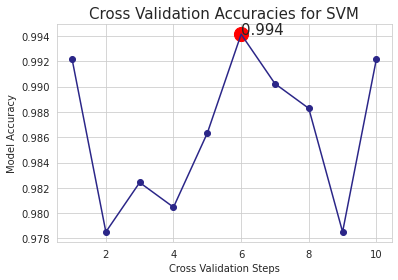

In [20]:
scatter_plots(svm_grid_result,'SVM')

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       643
           1       0.98      0.98      0.98       438
           2       1.00      0.98      0.99       190
           3       1.00      1.00      1.00         9

    accuracy                           0.99      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.99      0.99      0.99      1280



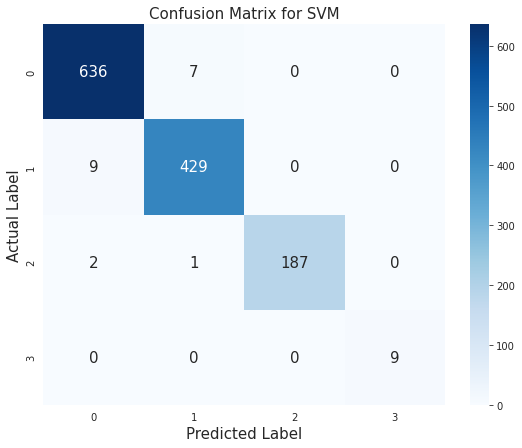

In [21]:
cf_plot(svm_grid_result,'SVM')

### 5.3 Random Forest

In [22]:

rf_model= RandomForestClassifier()
n_estimators = [10, 100, 500,1000]
max_features = ['sqrt', 'log2']

rf_grid = dict(n_estimators=n_estimators,max_features=max_features)
rf_grid_result  = train_model(rf_model,rf_grid)

rf_grid_result.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


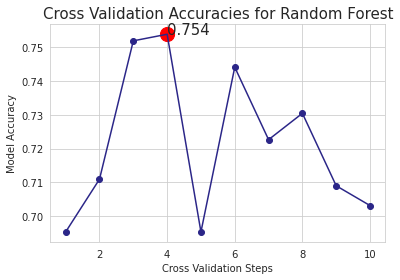

In [23]:
scatter_plots(rf_grid_result,'Random Forest')

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       643
           1       0.91      0.59      0.71       438
           2       1.00      0.08      0.16       190
           3       0.00      0.00      0.00         9

    accuracy                           0.71      1280
   macro avg       0.64      0.42      0.41      1280
weighted avg       0.79      0.71      0.66      1280



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


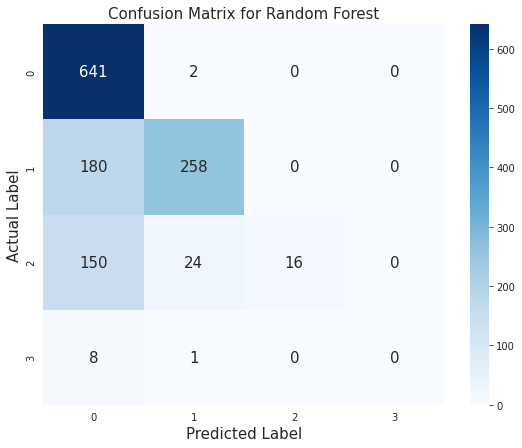

In [24]:
cf_plot(rf_grid_result,'Random Forest')

### MODEL COMPARISONS:

In [1]:
import pandas as pd

In [3]:

data = {'models': ["Logistic Regression","SVM","Random Forest"], 
        'accuracy': [0.75,0.99,0.71],
        'precision':[0.81,0.99,0.64],
        'recall':[0.73,0.99,0.42],
       }

# pass column names in the columns parameter 
df = pd.DataFrame.from_dict(data)
df

,models,accuracy,precision,recall
0,Logistic Regression,0.75,0.81,0.73
1,SVM,0.99,0.99,0.99
2,Random Forest,0.71,0.64,0.42
